Virginia Food Banks Dataset

In [199]:
# IMPORTS
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [200]:
def loadVAFoodBackData():
  VA_fb = pd.read_csv("DATA/VA_FoodBanks.csv")
  return VA_fb

VA_fb = loadVAFoodBackData()
print("")
print('---------------------------------------Original Data--------------------------------------------------------')
print(VA_fb.head(3))

#Removing data that may not be needed, can just remove a columns name from the list below to add it back
VA_fb = VA_fb.drop(columns=['Children Served via non-federal child nutrition programs','LAT','LON','MTW Status','Geopoint','Pounds of food distributed via non-federal child nutrition progr', 'FIPS', 'Households Served','Individuals Served'])
print("")
print('---------------------------------------Dropping un-needed columns--------------------------------------------')
print(VA_fb.head(3))

#missing = VA_fb.isnull().sum()
#print("")
#print('---------------------------------------NULL Values per column------------------------------------------------')
#print(missing)

#imputer = SimpleImputer(strategy='mean')
#numeric_columns = VA_fb.select_dtypes(include=['number']).columns
#VA_fb[numeric_columns] = imputer.fit_transform(VA_fb[numeric_columns])

#print("")
#print('---------------------------------------After filling null with mean------------------------------------------')
#missing = VA_fb.isnull().sum()
#print(missing)

print("")
print('---------------------------------------Data -----------------------------------------------')
VA_fb




---------------------------------------Original Data--------------------------------------------------------
   Year    Month   FIPS        Locality  Households Served  \
0  2020  October   97.0  King and Queen                NaN   
1  2019    April  115.0  Mathews County                NaN   
2  2019   August   97.0  King and Queen                NaN   

   Individuals Served  Pounds of Food Distributed  \
0                 NaN                    156644.0   
1                 NaN                     21602.0   
2                 NaN                     51338.0   

   Children Served via non-federal child nutrition programs  \
0                                                NaN          
1                                                0.0          
2                                                NaN          

   Pounds of food distributed via non-federal child nutrition progr  \
0                                                NaN                  
1                                

,Year,Month,Locality,Pounds of Food Distributed
0,2020,October,King and Queen,156644.00
1,2019,April,Mathews County,21602.00
2,2019,August,King and Queen,51338.00
3,2020,May,Northumberland County,67633.00
4,2019,May,King and Queen,54561.00
...,...,...,...,...
4254,2020,August,Richmond County,482661.00
4255,2019,August,Caroline County,29211.00
4256,2019,April,Bath County,16254.53
4257,2019,August,Norfolk City,561709.00


In [201]:
#creates a new dataset VA_fb_yearly that has the distribution combined into one yearly number
VA_fb_yearly = VA_fb.groupby(['Locality', 'Year'], as_index=False).agg({'Pounds of Food Distributed': 'sum'})
VA_fb_yearly

,Locality,Year,Pounds of Food Distributed
0,Accomack County,2019,1248586.00
1,Accomack County,2020,582136.00
2,Albemarle County,2019,2079115.91
3,Albemarle County,2020,2592132.03
4,Albemarle County,2021,1263395.72
...,...,...,...
366,Wythe County,2019,256434.29
367,Wythe County,2020,308196.67
368,Wythe County,2021,166407.74
369,York County,2019,605970.00


In [202]:
def loadPoverty():
  poverty = pd.read_csv('DATA/VA_Poverty.csv')
  return poverty

poverty = loadPoverty()
#Dropping state since ours is just virginia
poverty = poverty.drop(columns=['state'])
#Dropping the seperated data and keeping a total poverty number
columns_to_drop = ['B17020_002E','B17020_003E', 'B17020_004E', 'B17020_005E']
poverty['people_below_poverty_total'] = poverty['B17020_002E']
poverty = poverty.drop(columns=columns_to_drop)
#Changing date to only contain the year
poverty['year'] = pd.to_datetime(poverty['year']).dt.year
#Removing ",Virginia" from each county name so it can be matched with the food_bank if needed
poverty['county'] = poverty['county'].str.replace(', Virginia', '', regex=False)

poverty.head(3)

/var/folders/d7/hvzb6v5x007_z0nslxfml0f40000gn/T/ipykernel_36215/2452903014.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  poverty['year'] = pd.to_datetime(poverty['year']).dt.year


,year,county,B17020_001E,county 1,people_below_poverty_total
0,2018,Tazewell County,40559,185,6550
1,2015,Accomack County,32582,1,6384
2,2015,Albemarle County,95348,3,9714


### **Adding years 2019-2021 based on poverty growth rate (-0.8%, 0.1%, 0.2%) and population growth rates (.54%, .94%, .23%)**

In [203]:

#In here I am adding the years 2019-2021 based on Virginia population growth and poverty growth for those years

population_growth_rates = {
    2019: 0.0054,
    2020: 0.0094,
    2021: 0.0023
}
poverty_growth_rates = {
    2019: -0.008,
    2020: 0.001,
    2021: 0.002
}

counties = poverty['county'].unique()
new_rows = []

for county in counties:
  last_year_data = poverty[poverty['county'] == county].loc[poverty['year'] == 2018]
  if last_year_data.empty:
        print(f"No data found for {county} in 2018. Skipping.")
        continue
  last_population = last_year_data['B17020_001E'].iloc[0]
  last_poverty = last_year_data['people_below_poverty_total'].iloc[0]
  last_county = last_year_data['county 1'].iloc[0]
  for year in range(2019,2022):
    new_population = int(last_population * (1 + population_growth_rates[year]))
    last_population = new_population
    new_poverty = int(last_poverty * (1 + poverty_growth_rates[year]))
    last_poverty = new_poverty
    new_rows.append({
      'year': year,
      'county': county,
      'B17020_001E': new_population,
      'people_below_poverty_total': new_poverty,
      'county 1': last_county
    })

new_data = pd.DataFrame(new_rows)
poverty = pd.concat([poverty, new_data], ignore_index=True)

poverty = poverty.sort_values(by=['county', 'year']).reset_index(drop=True)

#removing county with non complete data
poverty = poverty.groupby('county').filter(lambda x: len(x) > 1)

poverty

No data found for Bedford city in 2018. Skipping.


,year,county,B17020_001E,county 1,people_below_poverty_total
0,2013,Accomack County,32730,1,6725
1,2014,Accomack County,32646,1,6697
2,2015,Accomack County,32582,1,6384
3,2016,Accomack County,32588,1,6341
4,2017,Accomack County,32345,1,6416
...,...,...,...,...,...
1193,2017,York County,65830,199,3446
1194,2018,York County,66052,199,3101
1195,2019,York County,66408,199,3076
1196,2020,York County,67032,199,3079


In [204]:
poverty_selected = poverty[poverty['year'] >= 2019]
poverty_selected = poverty_selected.rename(columns={'county': 'Locality', 'year': 'Year'})
combined_data = pd.merge(VA_fb_yearly, poverty_selected, how='inner', on=['Year','Locality'])
combined_data = combined_data.rename(columns={'B17020_001E': 'Total Population', 'county 1': 'County Num'})

combined_data

,Locality,Year,Pounds of Food Distributed,Total Population,County Num,people_below_poverty_total
0,Accomack County,2019,1248586.00,32570,1,6386
1,Accomack County,2020,582136.00,32876,1,6392
2,Albemarle County,2019,2079115.91,99425,3,9597
3,Albemarle County,2020,2592132.03,100359,3,9606
4,Albemarle County,2021,1263395.72,100589,3,9625
...,...,...,...,...,...,...
261,Wythe County,2019,256434.29,28754,197,4432
262,Wythe County,2020,308196.67,29024,197,4436
263,Wythe County,2021,166407.74,29090,197,4444
264,York County,2019,605970.00,66408,199,3076


## Linear Regression: Finding a Pattern between lbs. of Food Distributed and # of People in Poverty

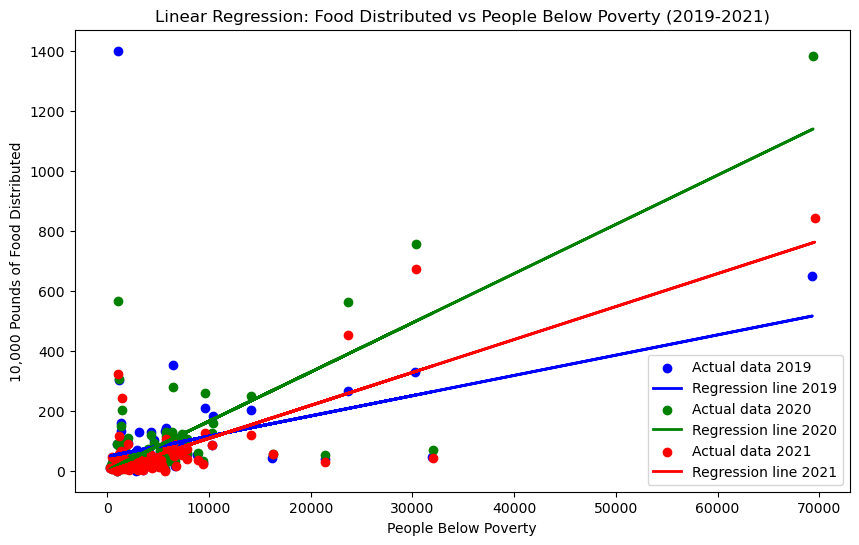

In [205]:
colors = {2019: 'blue', 2020: 'green', 2021: 'red'}
years = combined_data['Year'].unique()

plt.figure(figsize=(10, 6))

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    model_year = LinearRegression()
    model_year.fit(X_year, y_year)

    y_pred_year = model_year.predict(X_year)

    plt.scatter(X_year, y_year, color=colors[year], label=f'Actual data {year}')
    plt.plot(X_year, y_pred_year, color=colors[year], linewidth=2, label=f'Regression line {year}')

plt.xlabel('People Below Poverty')
plt.ylabel('10,000 Pounds of Food Distributed')
plt.title('Linear Regression: Food Distributed vs People Below Poverty (2019-2021)')
plt.legend()
plt.show()


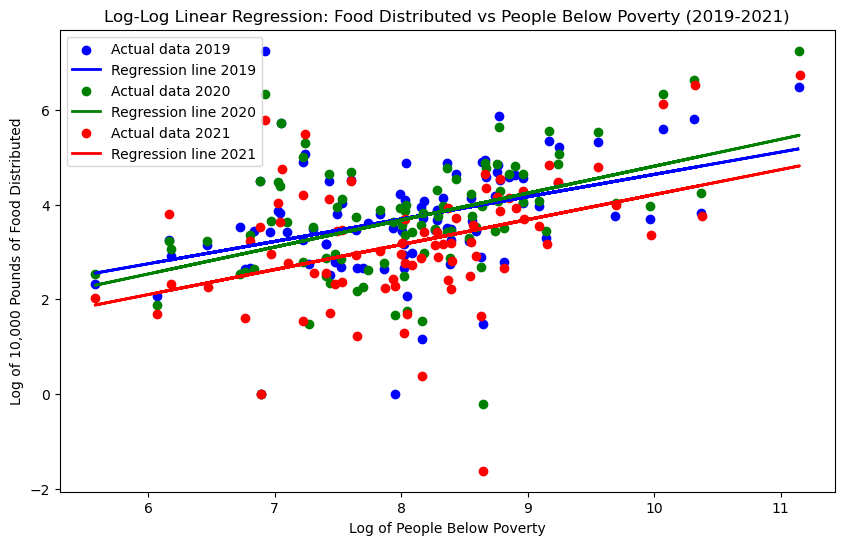

In [206]:
colors = {2019: 'blue', 2020: 'green', 2021: 'red'}
years = combined_data['Year'].unique()

plt.figure(figsize=(10, 6))

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    with np.errstate(divide='ignore'):
        X_log = np.log(X_year.replace(0, np.nan)).fillna(0)
        y_log = np.log(y_year.replace(0, np.nan)).fillna(0)
        #X_log = X_year
        #y_log = y_year

    model_year = LinearRegression()
    model_year.fit(X_log, y_log)

    y_pred_year = model_year.predict(X_log)

    plt.scatter(X_log, y_log, color=colors[year], label=f'Actual data {year}')
    plt.plot(X_log, y_pred_year, color=colors[year], linewidth=2, label=f'Regression line {year}')

plt.xlabel('Log of People Below Poverty')
plt.ylabel('Log of 10,000 Pounds of Food Distributed')
plt.title('Log-Log Linear Regression: Food Distributed vs People Below Poverty (2019-2021)')
plt.legend()
plt.show()


In [207]:
# Calculate residuals for each year
residuals = {}

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    with np.errstate(divide='ignore'):
        X_log = np.log(X_year.replace(0, np.nan)).fillna(0)
        y_log = np.log(y_year.replace(0, np.nan)).fillna(0)

    model_year = LinearRegression()
    model_year.fit(X_log, y_log)

    y_pred_year = model_year.predict(X_log)
    residuals[year] = y_log - y_pred_year

heavy_threshold = 1.0
light_threshold = 0.5

labels = {}
for year in years:
    labels[year] = residuals[year].apply(lambda x: '++' if x > heavy_threshold else 
                                         ('+' if x > light_threshold else 
                                          ('--' if x < -heavy_threshold else 
                                           ('-' if x < -light_threshold else '○'))))
    
combined_data['Pounds of Food Distributed'] = combined_data['Pounds of Food Distributed'].astype(int)
    
# Add value for lbs / person below poverty
combined_data['lbs_per_person_below_poverty'] = (combined_data['Pounds of Food Distributed'] / combined_data['people_below_poverty_total']).round(1)

# Add labels to the combined_data dataframe
combined_data['Supply'] = combined_data.apply(lambda row: labels[row['Year']].loc[row.name], axis=1)

# Add poverty rate 
combined_data['poverty_rate'] = ((combined_data['people_below_poverty_total'] / combined_data['Total Population']) * 100).round(2).astype(str) + '%'

# Sort by most under-served
combined_data_sorted = combined_data.sort_values(by='lbs_per_person_below_poverty', ascending=True)
#

output = combined_data_sorted[['Locality', 'Year', 'people_below_poverty_total', 'poverty_rate','Pounds of Food Distributed', 'lbs_per_person_below_poverty','Supply']]

output.to_csv('OUTPUT/SUPPLY.csv', index=False)